# Overview

This notebook provides a Hangman solver that can:
1. Run a single game and display each guessing step
2. Run many simulations to measure the solver's success rate for different numbers of allowed wrong guesses

In [12]:
import ast
import random
import matplotlib.pyplot as plt

# How the solver works

1. Load a dictionary of words. The file can be either:
   - a plain list of words (one per line) or
   - a Python dict where the keys are words.
2. Pick a random secret word from the dictionary.
3. Initialize game state:
   - pattern: the current known letters for example T___E for "table"
   - guessed: the set of letters already guessed
   - candidates: dictionary words that match the secret's length and letter count
4. Iterate guesses:
   - Compute positional letter frequencies from remaining candidates
   - Select the most likely letter (highest positional score). If no clear choice exists, pick a random unguessed letter
5. Update state after each guess:
   - If the guess is correct, reveal matching positions and filter candidates to match the updated pattern
   - If the guess is incorrect, increment the wrong-guess counter and remove candidates containing that letter
6. Repeat until the word is solved or the maximum allowed wrong guesses is reached
7. Return the result (solved or failed) and statistics such as steps and incorrect guesses

In [13]:
def load_words(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read().strip()

    try:
        data = ast.literal_eval(content)
        if isinstance(data, dict):
            return list(data.keys())
    except (ValueError, SyntaxError):
        pass

    return [line.strip() for line in content.splitlines() if line.strip()]


def matches_pattern(word, pattern):
    if len(word) != len(pattern):
        return False
    for w_ch, p_ch in zip(word.lower(), pattern):
        if p_ch != "_" and w_ch != p_ch.lower():
            return False
    return True


def positional_letter_frequencies(words, guessed):
    freqs = {}
    if not words:
        return freqs

    pos_counts = [dict() for _ in range(len(words[0]))]

    for w in words:
        for i, c in enumerate(w.lower()):
            if c.isalpha() and c not in guessed:
                pos_counts[i][c] = pos_counts[i].get(c, 0) + 1

    for pos in pos_counts:
        for c, count in pos.items():
            freqs[c] = freqs.get(c, 0) + count
    return freqs

# Single-game 

- A random word is chosen from the dictionary
- The solver makes guesses one by one
- Correct guesses are revealed in place; incorrect guesses reduce the remaining attempts
- Each step is displayed so you can follow the solver's progress

In [14]:
def simulate_single_game(words, max_incorrect=7, verbose=True):
    secret = random.choice(words)
    pattern = ["_" if c.isalpha() else c for c in secret]
    guessed = set()
    incorrect = 0
    steps = 0

    alpha_count = sum(c.isalpha() for c in secret)
    candidates = [
        w
        for w in words
        if len(w) == len(secret) and sum(c.isalpha() for c in w) == alpha_count
    ]

    if verbose:
        print("Chosen word:", "*" * len(secret))
        print("Start guessing...\n")

    while incorrect < max_incorrect and "_" in pattern:
        freqs = positional_letter_frequencies(candidates, guessed)
        if freqs:
            guess = max(freqs, key=freqs.get)
        else:
            remaining = [c for c in "abcdefghijklmnopqrstuvwxyz" if c not in guessed]
            if not remaining:
                break
            guess = random.choice(remaining)

        guessed.add(guess)
        steps += 1

        if guess in secret.lower():
            for i, ch in enumerate(secret.lower()):
                if ch == guess:
                    pattern[i] = secret[i].upper()
            candidates = [w for w in candidates if matches_pattern(w, pattern)]
        else:
            incorrect += 1
            candidates = [w for w in candidates if guess not in w.lower()]

        if verbose:
            print(f"Step {steps}: guessed '{guess}' -> {''.join(pattern)}")

    solved = "_" not in pattern
    if verbose:
        if solved:
            print("\nWord solved:", secret)
        else:
            print("\nFailed to solve:", secret)
        print(f"Steps: {steps}, Incorrect guesses: {incorrect}")
    return solved, steps

# Evaluating performance

- Run many games with a fixed maximum number of allowed incorrect guesses
- For each setting, record the amount of games the solver successfully completes

In [15]:
def run_experiment(words, trials=500, min_fails=5, max_fails=10):
    fail_rates = []
    for allowed in range(min_fails, max_fails + 1):
        successes = sum(
            simulate_single_game(words, allowed, verbose=False)[0]
            for _ in range(trials)
        )
        success_rate = successes / trials
        fail_rate = 1 - success_rate
        fail_rates.append(fail_rate)
        print(f"Max fails = {allowed}: success rate = {success_rate:.2%}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(min_fails, max_fails + 1), fail_rates, marker="o", color="blue")
    plt.title("Hangman Solver Error Rate vs Allowed Incorrect Guesses")
    plt.xlabel("Max Incorrect Guesses Allowed")
    plt.ylabel("Error Rate (Fail %)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

Chosen word: *****
Start guessing...

Step 1: guessed 'e' -> _____
Step 2: guessed 's' -> ____S
Step 3: guessed 'o' -> _O__S
Step 4: guessed 'l' -> _O_LS
Step 5: guessed 'w' -> _OWLS
Step 6: guessed 'b' -> _OWLS
Step 7: guessed 'c' -> _OWLS
Step 8: guessed 'f' -> _OWLS
Step 9: guessed 'h' -> HOWLS

Word solved: howls
Steps: 9, Incorrect guesses: 4
Max fails = 5: success rate = 86.80%
Max fails = 6: success rate = 92.20%
Max fails = 7: success rate = 95.80%
Max fails = 8: success rate = 97.80%
Max fails = 9: success rate = 98.60%
Max fails = 10: success rate = 99.80%


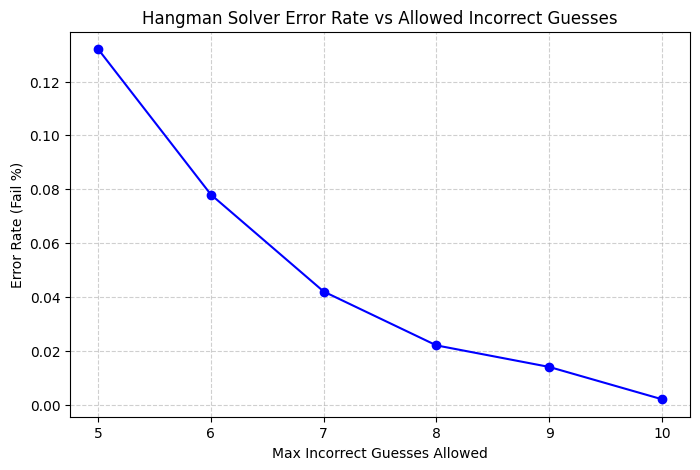

In [17]:
words = load_words("dictionary.txt")  

simulate_single_game(words, max_incorrect=7, verbose=True)
run_experiment(words, trials=500, min_fails=5, max_fails=10)